In [1]:
!gdown 19xU3kUyivRWGQzYXnpwlIjQqdfkD56v4

Downloading...
From: https://drive.google.com/uc?id=19xU3kUyivRWGQzYXnpwlIjQqdfkD56v4
To: /content/twitter_data.csv
100% 10.3M/10.3M [00:00<00:00, 112MB/s]


In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
data = pd.read_csv('/content/twitter_data.csv')
data

,id,user,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [5]:
data.isnull().sum()

,0
id,0
user,0
sentiment,0
tweet,686


In [63]:
data = data.dropna(axis=0)

In [64]:
X = data['tweet']
Y = pd.get_dummies(data['sentiment'])

In [65]:
num_classes = len(Y.columns)
num_classes

4

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [67]:

data['num_words'] = data['tweet'].apply(lambda x: len(x.split(" ")))

In [68]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower()

data['tweet'] = data['tweet'].apply(clean_text)

In [69]:
max_tokens = 3500

tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train.values)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [70]:
maxlen = 32

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [71]:
X_train.shape, X_test.shape

((59196, 32), (14800, 32))

In [72]:
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
model = Sequential()
model.add(Embedding(max_tokens, 32, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [74]:
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [76]:
history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    batch_size=64,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - loss: 1.2537 - precision_3: 0.5784 - recall_3: 0.1323 - val_loss: 0.9530 - val_precision_3: 0.7247 - val_recall_3: 0.4715
Epoch 2/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - loss: 0.8619 - precision_3: 0.7606 - recall_3: 0.5383 - val_loss: 0.8563 - val_precision_3: 0.7482 - val_recall_3: 0.5614
Epoch 3/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.7225 - precision_3: 0.8044 - recall_3: 0.6375 - val_loss: 0.7923 - val_precision_3: 0.7685 - val_recall_3: 0.6170
Epoch 4/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.5896 - precision_3: 0.8466 - recall_3: 0.7137 - val_loss: 0.7423 - val_precision_3: 0.7847 - val_recall_3: 0.6499
Epoch 5/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.4625 - precision_3: 0.8875 - recall_3: 0.7797 - val_loss: 0.7376 - val_precision_3: 0.7847 - val_recall_3: 0.6823
Epoch 6/20
740/740 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.3640 - precision_3: 0.9159 - recall_3: 0.8303 

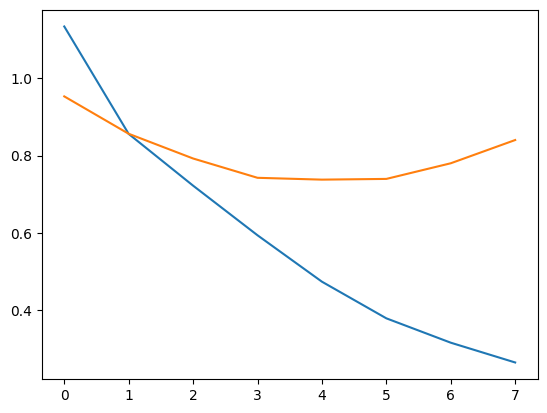

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.show()

In [78]:
preds = model.predict(X_test)

463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [80]:
print(classification_report(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.60      0.66      2517
           1       0.76      0.84      0.80      4554
           2       0.75      0.66      0.70      3642
           3       0.72      0.78      0.75      4087

    accuracy                           0.74     14800
   macro avg       0.74      0.72      0.73     14800
weighted avg       0.74      0.74      0.74     14800

